# LoFi v.s. subspaceEKF

In [292]:
import jax
import einops
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Callable
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter.subspace_filter import subcify
from rebayes.low_rank_filter import lofi
from rebayes.datasets.datasets import load_mnist

In [28]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
res = load_mnist()
res = jax.tree_map(jnp.array, res)
(X_train, y_train), (X_test, y_test) = res
X_train = einops.rearrange(X_train, "obs width height -> obs (width height)")
X_test = einops.rearrange(X_test, "obs width height -> obs (width height)")

y_train_ohe = jax.nn.one_hot(y_train, 10)
y_test_ohe = jax.nn.one_hot(y_test, 10)

In [499]:
class NNet(nn.Module):
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [532]:
key = jax.random.PRNGKey(314)
model = NNet()
params_init = model.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

## LoFi agent

In [533]:
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):    
    # eval on all tasks test set
    yhat = agent.emission_mean_function(bel.mean, X_test).argmax(axis=1)
    acc = jnp.mean(yhat == y_test)
    
    out = {
        "acc": acc
    }
    
    return out

In [534]:
agent, recfn = lofi.init_classification_agent(
    model,
    X_train[:10],
    dynamics_weights=1.0,
    dynamics_covariance=1e-6,
    memory_size=20,
)

In [535]:
%%time
bel, outputs = agent.scan(
    initial_mean=params_init_flat,
    initial_covariance=1e-7,
    X=X_train[:1000],
    Y=y_train_ohe[:1000],
    progress_bar=False,
    callback=callback,
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)

CPU times: user 1min 12s, sys: 1.48 s, total: 1min 14s
Wall time: 29.3 s


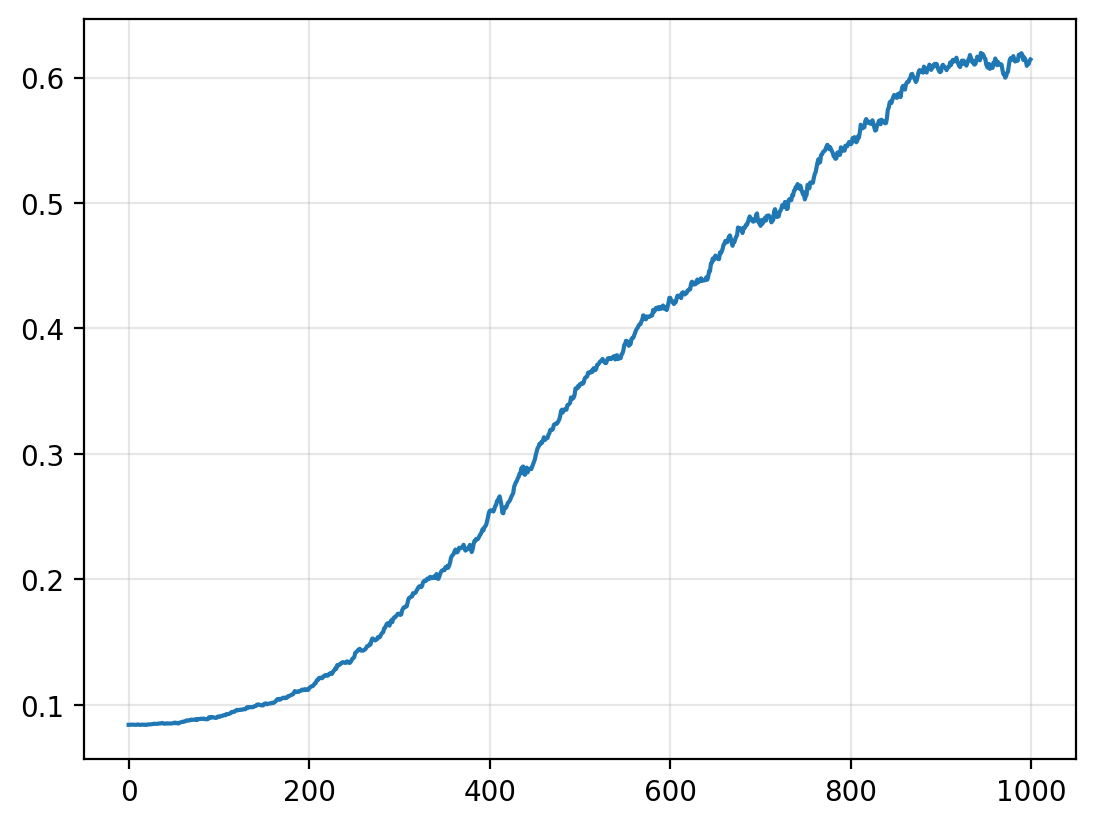

In [536]:
plt.plot(outputs["acc"])
plt.grid(alpha=0.3)

In [537]:
agent.predict_obs(bel, X_test).argmax(axis=1)

Array([7, 1, 1, ..., 7, 1, 6], dtype=int32)

In [538]:
yhat_test = agent.predict_obs(bel, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

Array(0.61439997, dtype=float32)

## Subspace agent

In [539]:
SubNNet = subcify(NNet)
dim_in = 28 ** 2

dim_subspace = 20
model_sub = SubNNet(dim_in, dim_subspace=dim_subspace)

params_init = model_sub.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

In [540]:
P = params_init["fixed"]["P"]
P = P / jnp.linalg.norm(P, axis=0)

params_init["fixed"]["P"] = P

In [541]:
pfixed, psubspace_init = params_init["fixed"], params_init["params"]
psubspace_init_flat, recfn = ravel_pytree(psubspace_init)

In [542]:
def applyfn(psubspace, X):
    pfull = {
        "fixed": pfixed,
        "params": psubspace
    }
    return model_sub.apply(pfull, X)

In [543]:
dynamics_weights=1.0
dynamics_covariance=1e-6
method="fcekf"

In [544]:
def apply_fn(flat_params, x):
    return applyfn(recfn(flat_params), x)

def emission_cov_fn(flat_params, x, eps=1e-6):
    p = apply_fn(flat_params, x).ravel()
    return eps * jnp.eye(len(p)) + jnp.diag(p) - jnp.outer(p, p)

agent = ekf.RebayesEKF(
    dynamics_weights_or_function=dynamics_weights,
    dynamics_covariance=dynamics_covariance,
    emission_mean_function=apply_fn,
    emission_cov_function=emission_cov_fn,
    adaptive_emission_cov=False,
    emission_dist = lambda mean, cov: tfd.Categorical(probs=mean),
    method=method,
)

In [545]:
%%time
bel, outputs = agent.scan(
    initial_mean=psubspace_init_flat,
    initial_covariance=1e-7,
    X=X_train[:1000],
    Y=y_train_ohe[:1000],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)

CPU times: user 37 s, sys: 479 ms, total: 37.4 s
Wall time: 21 s


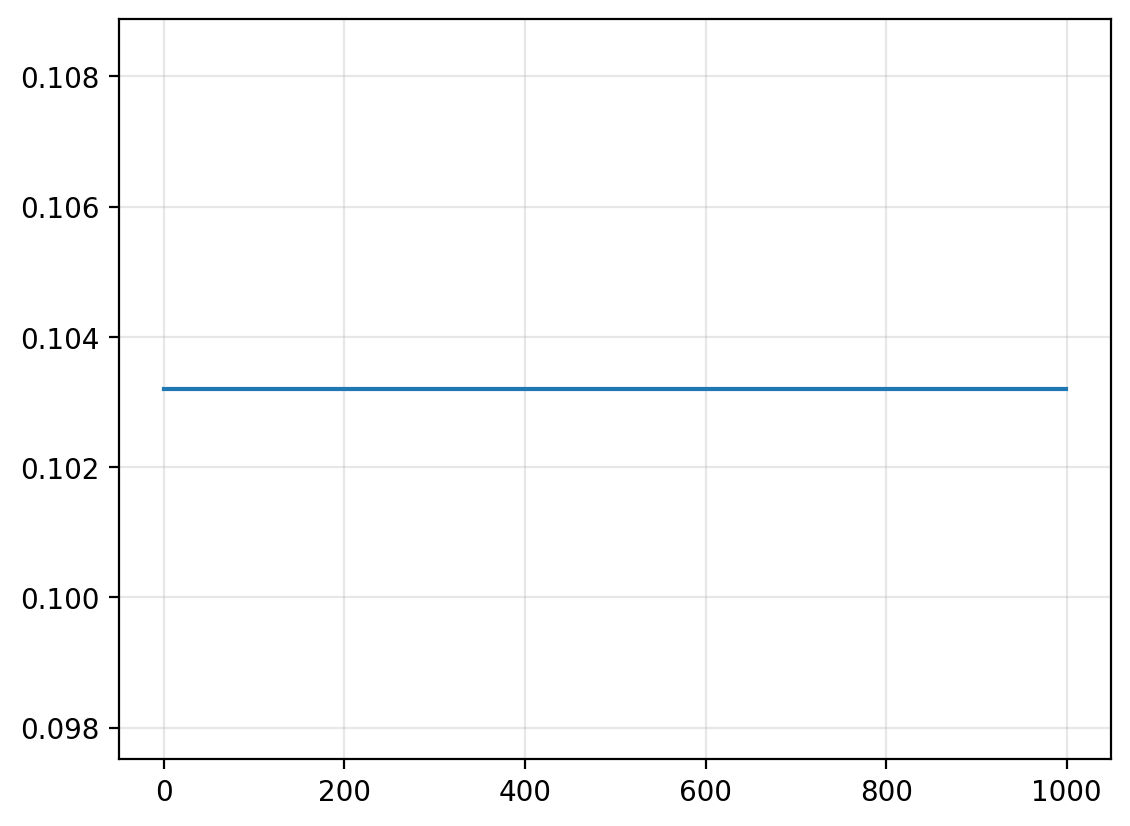

In [546]:
plt.plot(outputs["acc"])
plt.grid(alpha=0.3)

In [528]:
apply_fn(bel.mean, X_test)[:, 0]

Array([0.09973466, 0.09973758, 0.09973064, ..., 0.09974118, 0.09973322,
       0.09973734], dtype=float32)

In [526]:
yhat_test = apply_fn(bel.mean, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

Array(0.1032, dtype=float32)

In [459]:
psubspace_init_flat

Array([ 0.00696627,  0.00554405, -0.02024065, -0.00067848,  0.00410194,
       -0.01721293,  0.00460709,  0.00021611, -0.00058186,  0.01055648,
        0.00691188,  0.00215736, -0.00032204, -0.02113763,  0.01399151,
        0.01192655,  0.00699835,  0.00467775, -0.0083865 ,  0.01283646],      dtype=float32)

In [460]:
bel.mean

Array([ 0.00336398,  0.02664538, -0.00627503,  0.00456113, -0.01076677,
       -0.01905362,  0.02497306,  0.00411867, -0.02432215,  0.00800437,
       -0.02023129,  0.02097681, -0.0116717 , -0.05433721,  0.02332493,
        0.00489296,  0.04204793,  0.00580164,  0.01177204,  0.00282196],      dtype=float32)